In [177]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
img_size = 400

In [178]:
def generate_image(image_C,image_S):
    content_image = np.array(Image.open(image_C).resize((img_size,img_size)))
    content_image = tf.constant(np.reshape(content_image,((1,)+content_image.shape)))

    style_image = np.array(Image.open(image_S).resize((img_size,img_size)))
    style_image = tf.constant(np.reshape(style_image,((1,)+style_image.shape)))

    imshow(content_image[0])
    return content_image,style_image

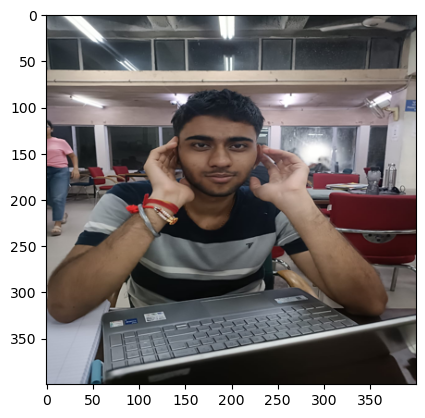

In [179]:
content_image,style_image = generate_image('my_content.jpg','my_style.jpg')

In [180]:
def compute_content_cost(content_output, generated_output):

    # content_output & generated_output should be of shape = (1,1,n_H,n_W,n_C)

    a_C = content_output[-1]
    a_G = generated_output[-1]
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=(_,-1,n_C))
    a_G_unrolled = tf.reshape(a_G, shape=(_,-1,n_C))

    cost_cost = tf.reduce_sum(tf.square(a_C_unrolled-a_G_unrolled))/(4*n_H*n_C*n_W)

    return cost_cost

In [181]:
def create_gram_matrix(matrix):

    # matrix received should be of shape = (n_C, n_H*n_W)

    return tf.matmul(matrix,tf.transpose(matrix))

In [182]:
def compute_layer_style_cost(a_S, a_G):

    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_S_unrolled = tf.transpose(tf.reshape(a_S,shape = (-1,n_C)))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,shape = (-1,n_C)))

    gram_S = create_gram_matrix(a_S_unrolled)
    gram_G = create_gram_matrix(a_G_unrolled)

    style_cost = tf.reduce_sum(tf.square(gram_S-gram_G))/(2*n_C*n_H*n_W)**2

    return style_cost

In [183]:
tf.random.set_seed(5130) 

vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False

In [184]:
for layer in vgg.layers:
    print(layer.name)

input_layer_7
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [185]:
# we will take Content layer = block5_conv4 (it is deeper layer so it will capture the high level features of the image)
# For style we need to capture low level as well as high level features & also take style cost for each style layer

STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]

CONTENT_LAYER = [('block5_conv4', 1)]

In [186]:
def compute_style_cost(style_image_output, generated_image_output, style_layers = STYLE_LAYERS):
    
    a_S = style_image_output[:-1]
    a_G = generated_image_output[:-1]

    style_cost = 0
    
    i = 0
    for weight in style_layers:
        style_cost += weight[1]*compute_layer_style_cost(a_S[i], a_G[i])
        i += 1
    
    return style_cost

In [187]:
def total_cost(J_content, J_style, alpha = 10, beta=40):
    return alpha*J_content+beta*J_style

In [188]:
def initialise_generated_image(content_image):

    generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
    noise = tf.random.uniform(tf.shape(generated_image),-0.25,0.25)
    generated_image = tf.add(generated_image,noise)

    generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

    imshow(generated_image[0])

    return generated_image

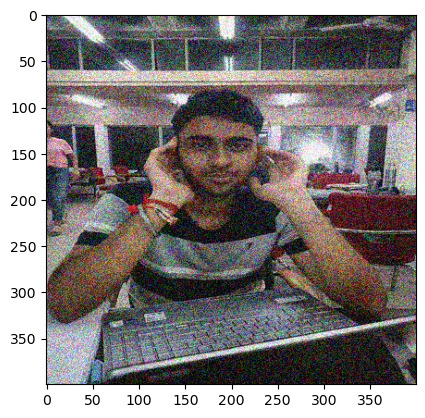

In [189]:
generated_image = initialise_generated_image(content_image)

In [190]:
def get_layer_outputs(vgg,layer_names):

    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.inputs],outputs)
    return model

In [191]:

vgg_model_outputs = get_layer_outputs(vgg,STYLE_LAYERS+CONTENT_LAYER)

In [192]:
preprocessed_content = tf.Variable(tf.image.convert_image_dtype(content_image,tf.float32))
a_C = vgg_model_outputs(preprocessed_content)  # Content encoder

preprocessed_style = tf.Variable(tf.image.convert_image_dtype(style_image,tf.float32))
a_S = vgg_model_outputs(preprocessed_style)    # Style encoder


In [193]:
def clip_0_1(tensor):
    return tf.clip_by_value(tensor, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor) > 3: tensor = tensor[0]
    return Image.fromarray(tensor)

In [194]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.03)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        a_G = vgg_model_outputs(generated_image)
        
        J_content = compute_content_cost(a_C,a_G)
        J_style = compute_style_cost(a_S,a_G)
        
        J = total_cost(J_content, J_style)
    
    grad = tape.gradient(J,generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    return J

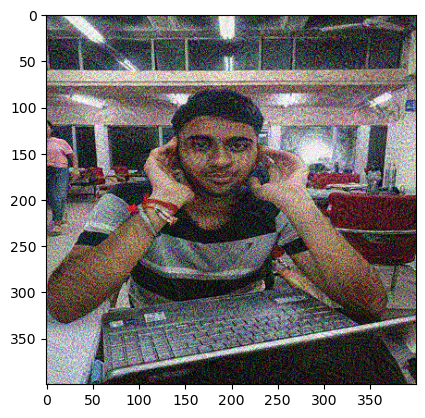

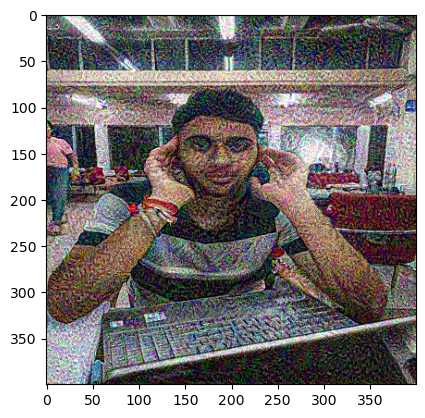

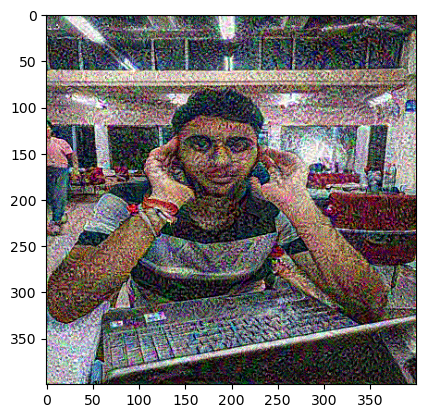

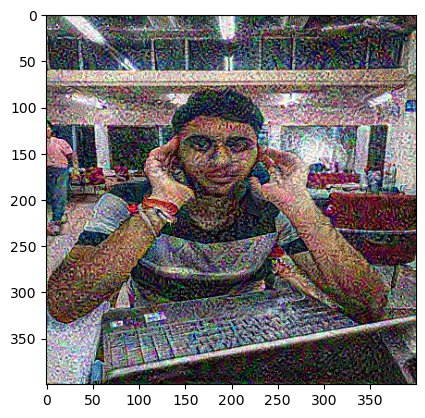

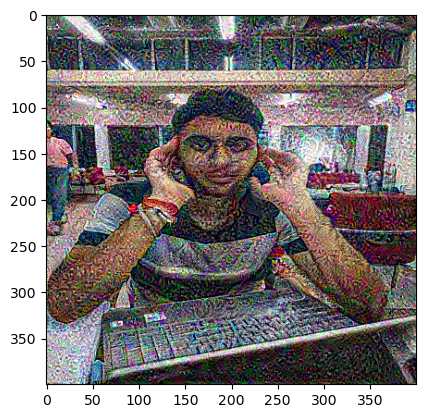

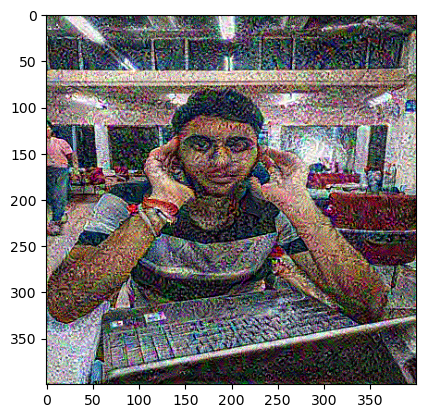

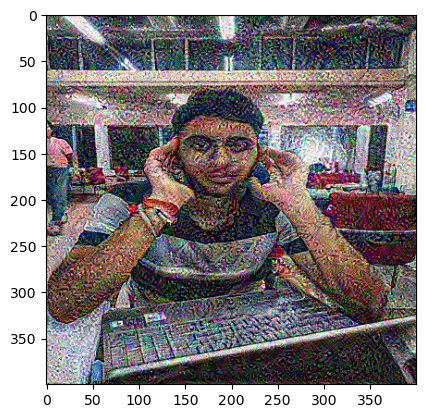

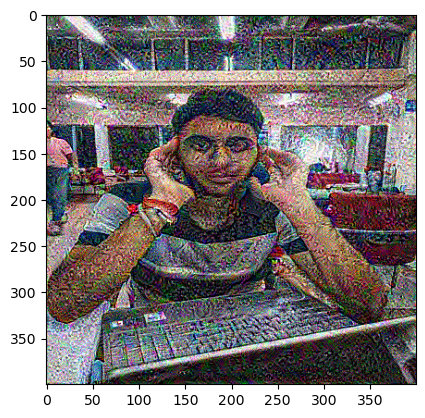

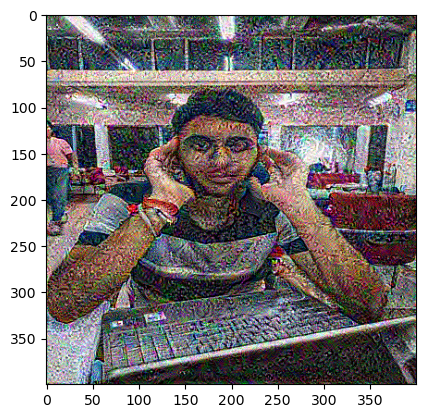

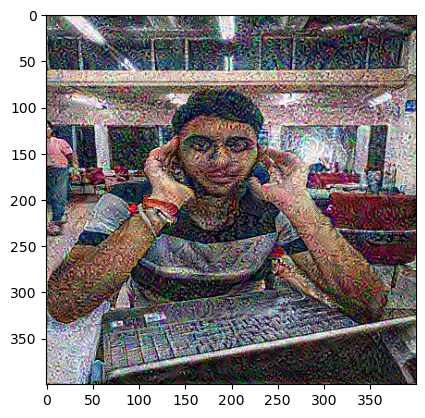

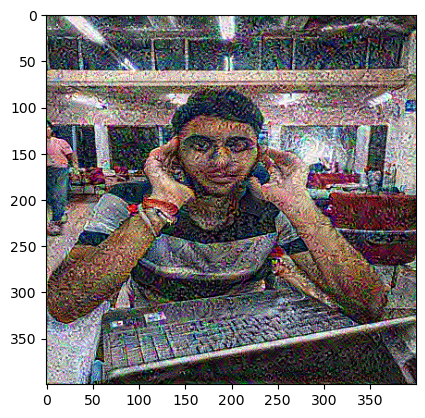

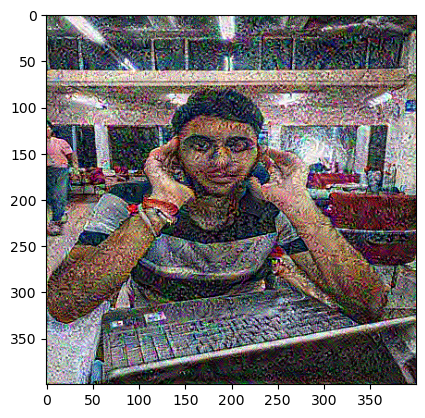

KeyboardInterrupt: 

In [195]:
epochs = 201
generated_image = tf.Variable(tf.image.convert_image_dtype(generated_image,tf.float32))
for i in range(epochs):
    train_step(generated_image)
    if i%10 == 0:
        image = tensor_to_image(generated_image)
        imshow(image)
        plt.show()
